# Importing Necessary Libraries

In [29]:
import numpy as np
import os
import cv2
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Defining Helper Functions

In [30]:
def find_Class(directory_path):
    if not os.path.exists(directory_path):
        raise ValueError(f"The directory '{directory_path}' does not exist.")
    if not os.path.isdir(directory_path):
        raise ValueError(f"The path '{directory_path}' is not a directory.")
    
    # Get a list of all entries in the directory
    all_entries = os.listdir(directory_path)
    
    # Filter out only directories
    folders = [entry for entry in all_entries if os.path.isdir(os.path.join(directory_path, entry))]
    
    return folders

# Setting Up Directory and Categories

In [31]:
DIRECTORY = r'C:/Users/motun/Downloads/CK+_dataset'
CATAGORIES = []
try:
    folders = find_Class(DIRECTORY)
    print(f"Directories in '{DIRECTORY}':")
    for folder in folders:
        CATAGORIES.append(folder)
except ValueError as e:
    print(e)

# Define the image size
image_size = (48, 48)

# Define your categories and directory
CATAGORIES = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
DIRECTORY = 'C:/Users/motun/Downloads/CK+_dataset'  # Replace with the path to your images

Directories in 'C:/Users/motun/Downloads/CK+_dataset':


# Loading and Preprocessing Data

In [32]:
data = []
labels = []

for category in CATAGORIES:
    folder = os.path.join(DIRECTORY, category)
    label = CATAGORIES.index(category)
    
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img_arr is not None:  # Check if the image is successfully loaded
            img_arr = cv2.resize(img_arr, (48, 48))  # Resize to 48x48
            data.append(img_arr)
            labels.append(label)
        else:
            print(f"Failed to load image {img_path}")
            
data = np.array(data)
labels = np.array(labels)

# Normalize the images
data = data / 255.0

# Add a channel dimension
data = np.expand_dims(data, axis=-1)

# Convert labels to categorical
labels = to_categorical(labels, num_classes=len(CATAGORIES))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Data Augmentation

In [33]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator to the training data
datagen.fit(X_train)

# Enabling Mixed Precision Training

In [34]:
mixed_precision.set_global_policy('mixed_float16')

# Defining the Model

In [35]:
# Define the model
model = Sequential()

# Add convolutional layers with input shape specified in the first layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a flatten layer
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
#model.add(Dropout(0.5))

# Add output layer
model.add(Dense(len(CATAGORIES), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 839,815 (3.20 MB)

 Trainable params: 839,431 (3.20 MB)

 Non-trainable params: 384 (1.50 KB)

# Defining Callbacks

In [36]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Training the Model

In [27]:
# Train the model using data augmentation with callbacks
history = model.fit(datagen.flow(X_train, y_train, batch_size=64), 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 626ms/step - accuracy: 0.2063 - loss: 5.1877 - val_accuracy: 0.2741 - val_loss: 4.7453 - learning_rate: 1.0000e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 624ms/step - accuracy: 0.3734 - loss: 4.5431 - val_accuracy: 0.1218 - val_loss: 4.6850 - learning_rate: 1.0000e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 648ms/step - accuracy: 0.4783 - loss: 4.1548 - val_accuracy: 0.1269 - val_loss: 4.6413 - learning_rate: 1.0000e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 630ms/step - accuracy: 0.5622 - loss: 3.9338 - val_accuracy: 0.1574 - val_loss: 4.6104 - learning_rate: 1.0000e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 637ms/step - accuracy: 0.6268 - loss: 3.6876 - val_accuracy: 0.1574 - val_loss: 4.6235 - learning_rate: 1.0000e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 634ms/step - accuracy: 0.6510 - loss: 3.5622 - val_accuracy: 0.1827 - val_loss: 4.6169 - learning_rate: 1.0000e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 632ms/step - ac

# Evaluating the Model

In [28]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f'Train accuracy: {train_accuracy*100:.2f}%')

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9876 - loss: 1.3401
Train accuracy: 98.98%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9626 - loss: 1.4295
Test accuracy: 96.95%


# Save the model

In [11]:
# Save the model
model.save('C:/Users/motun/Downloads/saved_model.keras')

# Plotting Accuracy and Loss

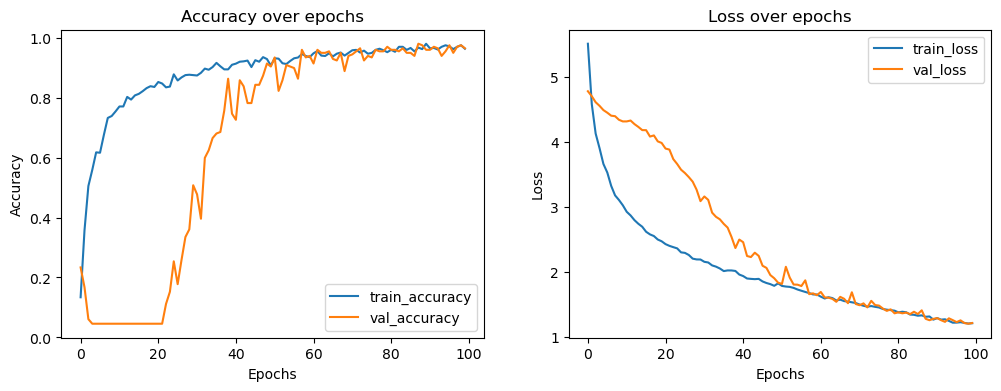

In [12]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

plt.show()

# Load and preprocess the image

In [81]:
# Load and preprocess the image
from tensorflow.keras.preprocessing import image
img_pred = image.load_img(r"C:\Users\motun\OneDrive\Desktop\Random_test\surprise1.png", target_size=(48, 48), color_mode='grayscale')
img_pred = image.img_to_array(img_pred)
img_pred = img_pred / 255.0  # Normalize the image
img_pred = np.expand_dims(img_pred, axis=0)  # Add batch dimension
img_pred = np.expand_dims(img_pred, axis=-1)  # Add channel dimension if missing

# Make prediction
rslt = model.predict(img_pred)

# Print results
print(rslt)
print(CATAGORIES[np.argmax(rslt)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
[[0.1426 0.1404 0.1462 0.146  0.1323 0.1449 0.1473]]
surprise


In [82]:
# Load and preprocess the image
from tensorflow.keras.preprocessing import image
img_pred = image.load_img(r"C:\Users\motun\OneDrive\Desktop\Random_test\disgust.png", target_size=(48, 48), color_mode='grayscale')
img_pred = image.img_to_array(img_pred)
img_pred = img_pred / 255.0  # Normalize the image
img_pred = np.expand_dims(img_pred, axis=0)  # Add batch dimension
img_pred = np.expand_dims(img_pred, axis=-1)  # Add channel dimension if missing

# Make prediction
rslt = model.predict(img_pred)

# Print results
print(rslt)
print(CATAGORIES[np.argmax(rslt)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[0.1451 0.1434 0.1512 0.1439 0.1342 0.1406 0.1411]]
disgust


In [83]:
# Load and preprocess the image
from tensorflow.keras.preprocessing import image
img_pred = image.load_img(r"C:\Users\motun\OneDrive\Desktop\Random_test\contempt.png", target_size=(48, 48), color_mode='grayscale')
img_pred = image.img_to_array(img_pred)
img_pred = img_pred / 255.0  # Normalize the image
img_pred = np.expand_dims(img_pred, axis=0)  # Add batch dimension
img_pred = np.expand_dims(img_pred, axis=-1)  # Add channel dimension if missing

# Make prediction
rslt = model.predict(img_pred)

# Print results
print(rslt)
print(CATAGORIES[np.argmax(rslt)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.1444 0.1487 0.1476 0.1436 0.1354 0.1409 0.1409]]
contempt


In [84]:
# Load and preprocess the image
from tensorflow.keras.preprocessing import image
img_pred = image.load_img(r"C:\Users\motun\OneDrive\Desktop\Random_test\anger.png", target_size=(48, 48), color_mode='grayscale')
img_pred = image.img_to_array(img_pred)
img_pred = img_pred / 255.0  # Normalize the image
img_pred = np.expand_dims(img_pred, axis=0)  # Add batch dimension
img_pred = np.expand_dims(img_pred, axis=-1)  # Add channel dimension if missing

# Make prediction
rslt = model.predict(img_pred)

# Print results
print(rslt)
print(CATAGORIES[np.argmax(rslt)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[[0.1482 0.143  0.1444 0.1467 0.1294 0.1405 0.1472]]
anger


In [85]:
"C:\Users\motun\Downloads\20240613_015000.png"

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (3924610665.py, line 1)

In [86]:
# Load and preprocess the image
from tensorflow.keras.preprocessing import image
img_pred = image.load_img(r"C:\Users\motun\Downloads\20240613_015000.png", target_size=(48, 48), color_mode='grayscale')
img_pred = image.img_to_array(img_pred)
img_pred = img_pred / 255.0  # Normalize the image
img_pred = np.expand_dims(img_pred, axis=0)  # Add batch dimension
img_pred = np.expand_dims(img_pred, axis=-1)  # Add channel dimension if missing

# Make prediction
rslt = model.predict(img_pred)

# Print results
print(rslt)
print(CATAGORIES[np.argmax(rslt)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[[0.1442 0.1437 0.151  0.1469 0.1295 0.1425 0.1421]]
disgust
